In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload # reloads modules
# %aimport # lists what it will/won't reload

import os
import numpy as np
import pandas as pd

import nltk

from utils import *

import matplotlib.pyplot as plt
from IPython.display import IFrame, display

pd.options.display.max_columns = None

### Read

In [2]:
filenames = ["data/articles{}.csv".format(n) for n in [1,2,3]]

In [3]:
df = pd.concat([pd.read_csv(file, encoding='utf-8') for file in filenames], ignore_index=True)
df.drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 10 columns):
Unnamed: 0     142570 non-null int64
id             142570 non-null int64
title          142568 non-null object
publication    142570 non-null object
author         126694 non-null object
date           139929 non-null object
year           139929 non-null float64
month          139929 non-null float64
url            85559 non-null object
content        142570 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 10.9+ MB


In [4]:
# remove rows with null dates, use date objects, and add day column to help filter
df.drop(df.index[df.date.isnull()], inplace=True)
df['date'] = df.date.apply(lambda x: x.replace('/', '-'))
df['date'] = pd.to_datetime(df.date)
df['day'] = df.date.map(lambda x: x.day)

In [5]:
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,31
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",19
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",6
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",10
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",2


### Gather and preprocess text

#### First we need stories from an islamic shooter
Lets try to "find" the two orlando stories now using cosine similarity of TFIDF vectors

In [6]:
orlando_date = (12, 6, 2016)
best_story_id = 20550

likely_or = get_similar_by_daterange_sid(df, orlando_date, best_story_id, 80, day_range=16)
# likely_or

Getting stories within 16 days of 6/12/2016 (within the same month)
Processing stories...
Calculating cosine similarity using tfidf: max_df=0.95, min_df=2
TFIDF vectorization complete. Calculating cosine similarity...


Wow! This actually worked super super well

In [7]:
stories_df, ignored_df = kmeans_split(likely_or, order_by_sid=20550)

print('ignored stories:')
# ignored_df

ignored stories:


Definite improvement, but for the sake of clean data lets pull out the last two unrelated stories

In [67]:
# df[df.id == 138649].content.values

In [8]:
to_remove = [5396,7555]
if np.any([stories_df.index.contains(i) for i in to_remove]):
    stories_df = stories_df.drop(to_remove)

print(len(stories_df))
stories_df

60


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16
6620,6620,24948,Omar Mateen Posted to Facebook Amid Orlando At...,New York Times,"Alan Blinder, Frances Robles and Richard Pérez...",2016-06-17,2016.0,6.0,NaN,"JENSEN BEACH, Fla. — The gunman who committ...",17
5410,5410,23326,Omar Mateen Told Police He’d Strap Bombs to Ho...,New York Times,Frances Robles and Richard Pérez-Peña,2016-06-17,2016.0,6.0,NaN,"ORLANDO, Fla. — Amid the massacre at a gay ...",17
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
3028,3028,20642,Orlando Police Defend Actions as Clock Ticked ...,New York Times,"Richard Pérez-Peña, Frances Robles and Eric Li...",2016-06-24,2016.0,6.0,NaN,Some details of the Orlando nightclub massacre...,24
111410,114873,169930,Orlando’s Deadly Mass Shooting: What We Know M...,NPR,Bill Chappell,2016-06-13,2016.0,6.0,http://www.npr.org/sections/thetwo-way/2016/06...,"One day after a depraved attack on an Orlando,...",13
2955,2955,20563,Obama Says Orlando Gunman Was Probably a Homeg...,New York Times,Julie Hirschfeld Davis,2016-06-14,2016.0,6.0,NaN,WASHINGTON — President Obama said Monday th...,14
138342,141805,212708,Gunman in Orlando pledged allegiance to ISIS; ...,Washington Post,Hayley Tsukayama,2016-06-12,2016.0,6.0,https://web.archive.org/web/20160613001042/htt...,ORLANDO — The gunman who opened fire...,12
3008,3008,20620,"‘Always Agitated. Always Mad’: Omar Mateen, Ac...",New York Times,"Dan Barry, Serge F. Kovaleski, Alan Blinder an...",2016-06-24,2016.0,6.0,NaN,"ORLANDO, Fla. — The brother of the bride ar...",24
138464,141927,212866,Troubled. Quiet. Macho. Angry. The volatile li...,Washington Post,Kevin Sullivan,2016-06-17,2016.0,6.0,https://web.archive.org/web/20160619005138/htt...,After a lifetime of angst and embarra...,17


In [68]:
58 / 60.

0.9666666666666667

> Precision is 96.7%

## Analysis

#### Investigation: taking a corpus from each of two shooting events, one with a muslim extremist shooter and one not, how do frequent words compare?
What about the word "terrorist" (absolute or relative to # of words/adjectives in the story)?

(12, 6, 2016)


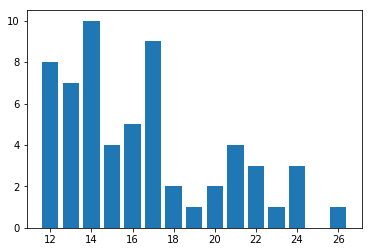

In [20]:
print(orlando_date)
stories_per_day = stories_df.day.value_counts(sort=False)
plt.bar(stories_per_day.index, stories_per_day)
# stories_df.day.hist(bins=14)
plt.show()

In [31]:
t = stories_df.date[2943]
print(t.day, t.dayofweek, t.weekday_name)

# pd.Series(index=stor)
# stories_per_day.index.map(lambda x: x+100)

16 3 Thursday


In [10]:
stories_df.day.max()

26

In [11]:
stories_df.publication.value_counts()

New York Times      13
Fox News            13
Washington Post      7
NPR                  6
Breitbart            5
CNN                  4
Reuters              4
New York Post        2
Business Insider     2
Buzzfeed News        2
Atlantic             1
National Review      1
Name: publication, dtype: int64

Ok shoot so we should expect more about the guy as a radical muslim terrorist. Prolly best to exclude BB at some point.

In [36]:
# some words to consider
terror_vocab  = ['terror', 'terrorist', 'terrorism', 'counterterrorism', 'isi', 'isis', 'isil', 'jihadi', 'jihadis', 'jihadism', 'jihadist', 'islamic', 'extremist', 'radical', 'radicalization', 'radicalized']
gun_vocab     = ['gun', 'handgun', 'rifle', 'pistol', 'weapon']
illness_vocab = ['unstable', 'troubled', 'delusional']
other_vocab   = ['dead', 'killed', 'shooter', 'gunman', 'shooting', 'gunfire', 'mourning']
unigram_vocab = terror_vocab + gun_vocab + illness_vocab + other_vocab
# some bigrams to consider
bi_terror_vocab  = ['terrorist attack', 'muslim extremist', 'islamic extremist', 'islamic state', 'al qaeda']
bi_gun_vocab     = ['second amendment']
bi_illness_vocab = ['mental illness']
bi_other_vocab   = ['thoughts and prayers']
bigram_vocab     = bi_terror_vocab + bi_gun_vocab + bi_illness_vocab + bi_other_vocab

illness_all = illness_vocab + bi_illness_vocab
terror_all  = terror_vocab + bi_terror_vocab
guns_all    = gun_vocab + bi_gun_vocab
other_all   = other_vocab + bi_other_vocab

In [37]:
def count_bigrams_as_df(df, vocab=None):
    docs = df_to_stringlist(df)
    tf_vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,2), vocabulary=vocab)
    tf = tf_vectorizer.fit_transform(docs)
    return vec_output_to_df(tf_vectorizer, tf)

def reduce_vocab(count_df):
    df = pd.DataFrame()
    df['gun'] = count_df['rifle'] + count_df['gun'] + count_df['pistol']
    df['terrorist'] = count_df[['terror', 'terrorist']].agg('sum', axis=1)

In [38]:
# forunately the days don't spill over to the next month
group = stories_df.groupby('day')

# two ways to do it...
word_counts_day = [count_bigrams_as_df(gdf, vocab=unigram_vocab + bigram_vocab) for name, gdf in group]
# count_group = group.apply(count_bigrams_as_df)

In [39]:
# word_counts_day[7][vocab]#.sum(axis=1).mean()
group.get_group(20)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
138508,141971,212919,What the Orlando gunman told the police during...,Washington Post,Matt Zapotosky,2016-06-20,2016.0,6.0,https://web.archive.org/web/20160621001425/htt...,As he talked on the phone with dispatch...,20
35728,36532,55359,"Under pressure, FBI releases full content of O...",CNN,NaN,2016-06-20,2016.0,6.0,NaN,(CNN) The FBI on Monday afternoon released a ...,20


In [40]:
def sum_daily_vocab(cdf, vocab):
#     return cdf.mean(axis=0)[vocab].sum() # story mean then sum?
#     return cdf[vocab].sum(axis=1).mean() # or... wait what?
    return cdf.sum(axis=0)[vocab].sum() # nah, just sum up the total daily usages of terms in vocab

gun vocab:  [36, 23, 35, 18, 24, 33, 1, 6, 10, 13, 6, 4, 5, 11]
terror vocab:  [106, 63, 136, 58, 67, 107, 52, 2, 45, 31, 32, 1, 36, 7]
illness vocab:  [2, 1, 7, 1, 0, 6, 0, 1, 1, 0, 0, 0, 0, 0]
shooting vocab:  [124, 55, 117, 40, 71, 108, 10, 9, 30, 31, 25, 14, 24, 22]


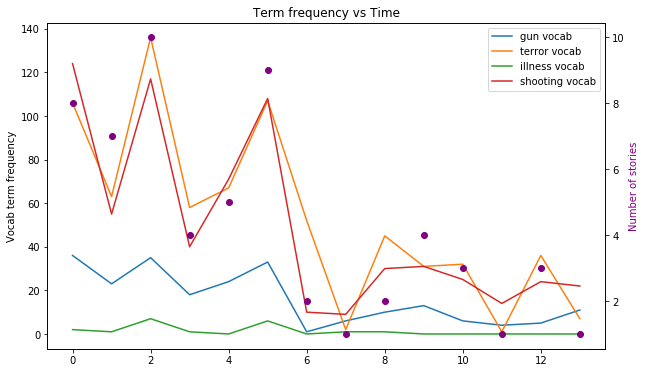

In [71]:
subject_vocab = {
    'gun': guns_all,
    'terror': terror_all,
    'illness': illness_all,
    'shooting': other_vocab,
}

subject_freq = {}

### PLOT

fig, ax1 = plt.subplots(figsize=(10,6))

# ax1.plot(t, s1, 'b-')
# ax1.set_xlabel('time (s)')


# ax2.plot(t, s2, 'r.')

for subj, vocab in subject_vocab.items():
    label = subj + ' vocab'
    usage_by_day = [sum_daily_vocab(cdf, vocab) for cdf in word_counts_day] # i.e. for each day
    print(label + ': ', usage_by_day)  
    subject_freq[subj] = usage_by_day

    ax1.plot(usage_by_day, label=label)

plt.ylabel('Vocab term frequency')
plt.legend()
    
ax2 = ax1.twinx()
ax2.plot(stories_per_day.values, 'o', color='purple')
# plt.ylabel()
ax2.set_ylabel('Number of stories', color='purple')

plt.title('Term frequency vs Time')
plt.xlabel('Days after shooting')

plt.show()

>Results suggest a few things:
* Guns are not the focus of any of the articles for this event
* Mental illnss is not discussed
* This ties to terrorism are discussed alot however--perhaps there's typically not overlap between mental illness and terrorism discussions -> can terrorists even be mentally ill according to our zeitgeist?
* Note: the shooting vocab is serving as a baseline in a way--we expect that sort of language to certainly be in a story about a shooting.

In [58]:
# print(np.array(subject_freq['terror']), np.array(subject_freq['gun']))

np.delete(np.array(subject_freq['terror'])/ np.array(subject_freq['gun']),6).mean() # remove outlier

3.0356344603000118

> On avg terror vocab words were used about 3x as often as gun words

In [ ]:
porter = PorterStemmer()
snowball = SnowballStemmer("english")

list(zip([porter.stem(v) for v in unigram_vocab], [snowball.stem(v) for v in unigram_vocab]))

In [ ]:
snowball.stem('us')

In [78]:
# df[df.id == 20550].content.values
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

In [86]:
tokenize('mouse mice nice nicest nicer ' + ' '.join(terror_vocab))
# pos_tag(['loving'])
# pos_

['mouse',
 'mouse',
 'nice',
 'nicest',
 'nicer',
 'terror',
 'terrorist',
 'terrorism',
 'counterterrorism',
 'isi',
 'isi',
 'isil',
 'jihadi',
 'jihadis',
 'jihadism',
 'jihadist',
 'islamic',
 'extremist',
 'radical',
 'radicalization',
 'radicalized']